In [1]:
##get the first frame of the project video

import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip1 = VideoFileClip("project_video.mp4")
clip1.save_frame("project_video_1st_frame.jpeg")





In [2]:
##define the gradient functions 

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    binary_output = sxbinary # Remove this line
    return binary_output # Calculate directional gradient

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    angle = np.arctan(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(angle)
    binary_output[(angle > thresh[0]) & (angle < thresh[1])] = 1
    return binary_output


def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output


720 1280


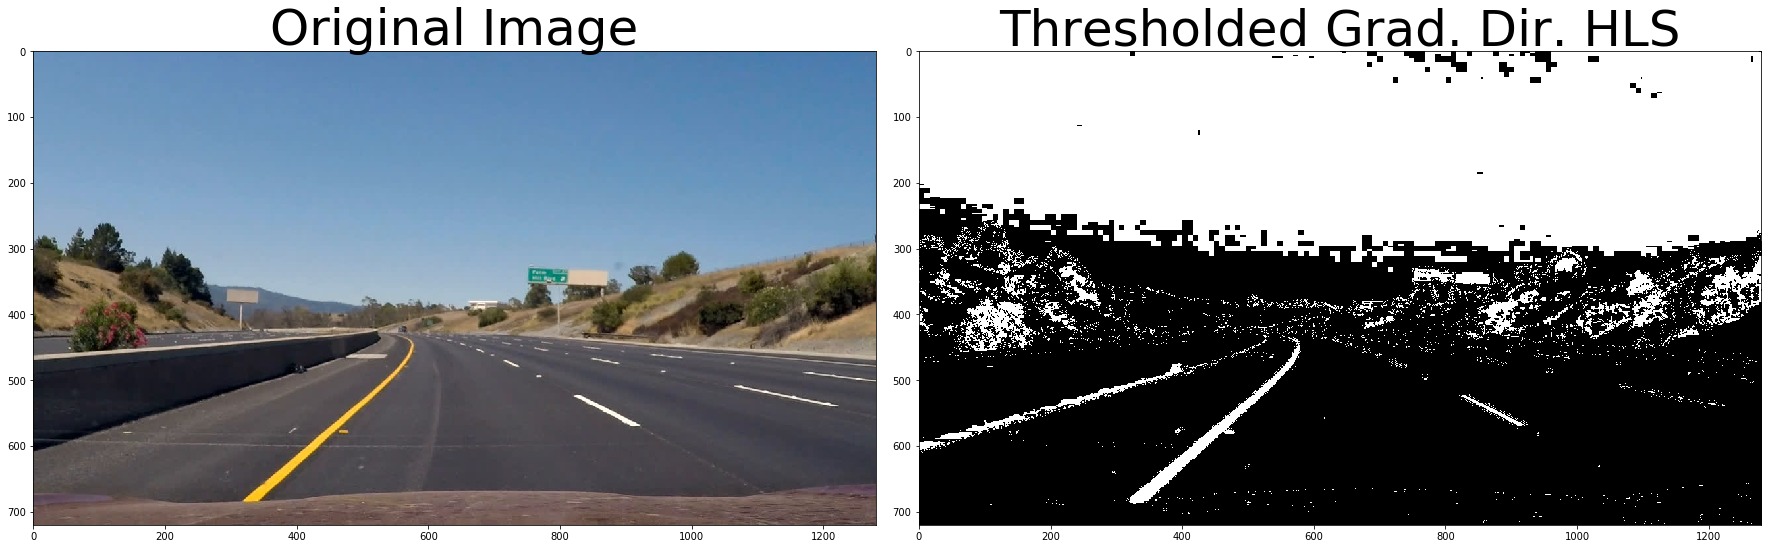

In [3]:
##apply the combined gradient thresholds to the first frame of the video

image = mpimg.imread('project_video_1st_frame.jpeg')


ksize = 15 
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
hls_binary = hls_select(image, thresh = (90, 255))

combined = np.zeros_like(dir_binary)
##combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
##combined[((gradx == 1) & (grady == 1)) | (((mag_binary == 1)|(hls_binary ==1)) & (dir_binary == 1))] = 1
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))|(hls_binary ==1)] = 1



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir. HLS', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


print(image.shape[0], image.shape[1])

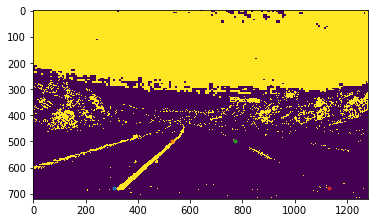

In [4]:
##find 4 points, for perspective transformation
plt.imshow(combined)
plt.plot(310, 680, '.')
plt.plot(530, 500, '.')
plt.plot(770, 500, '.')
plt.plot(1130, 680, '.')

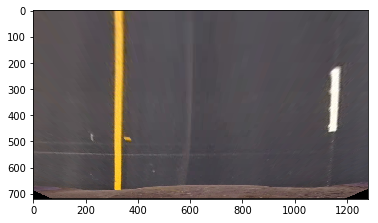

In [6]:
def image_warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[310, 680],[530, 500],[770, 500],[1130, 680]])
    dst = np.float32([[300, 680],[300, 0],[1130, 0],[1130, 680]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

warped_image = image_warp(image)
plt.imshow(warped_image)


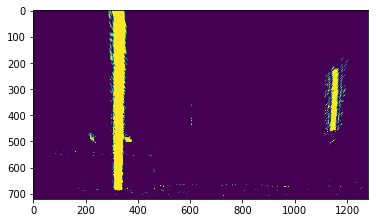

In [7]:

binary_warped = image_warp(combined)
plt.imshow(binary_warped)

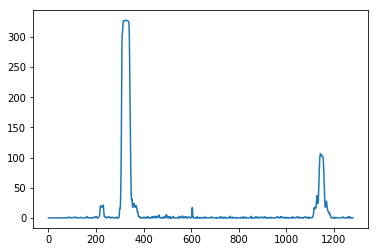

In [8]:

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

(720, 0)

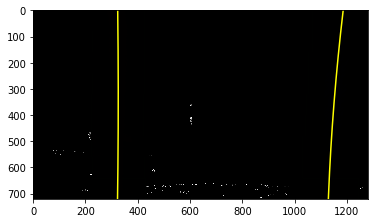

In [9]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
nwindows = 9

window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



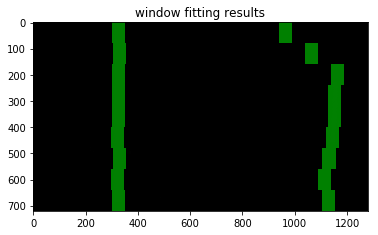

In [10]:

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids
warped = binary_warped
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


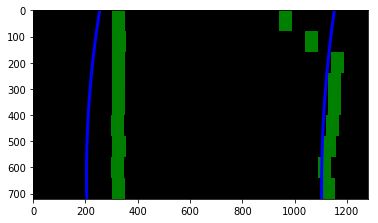

In [11]:
plt.imshow(output)

# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 1e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([1100 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
#plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
#plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='blue', linewidth=3)
plt.plot(right_fitx, ploty, color='blue', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [12]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48


3874.86458294 4655.09948167


In [13]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

1271.59813236 m 1528.76077262 m


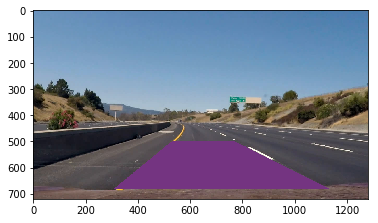

In [14]:



points = np.array([[310, 680],[530, 500],[770, 500],[1130, 680]])
cv2.fillPoly(image, np.int32([points]), (116,52, 129))

plt.imshow(image)